# Capstone Project

## Introduction


Load forecasting is a basic demand for utility to prepare for daily operation as well as planning for future growth. One challenge is to forecast on multiple buildings at the same time . A possible solution is to do clustering before forecasting to limit the time on building the models. This project will first do clustering to find similarities on the building energy usage and then trying to build a model for each cluster for load forecasting.

The data source used here is on AWS S3 (https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=nrel-pds-building-stock%2Fend-use-load-profiles-for-us-building-stock%2F2021%2F). Data wrangling is done beforehand to clean the data and stored in a personal S3 bucket

## Data Preparation

In order to save time when loading data, the following code is prepared to save data in pandas dataframe and save it in pickle.
To access S3 properly a key and secret file is used for proper accessing bucket.

In [13]:
import pandas as pd
import numpy as np
import boto3
import smart_open
cred = pd.read_csv('keys_FZ1991IAM.csv')
AWS_ACCESS_KEY_ID = cred['Access key ID'].iloc[0]
AWS_SECRET_ACCESS_KEY = cred['Secret access key'].iloc[0]

comURI = "s3://mybucket19910119/com/"
resURI = "s3://mybucket19910119/res_sm/"
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

Extracting the file in S3 and then creating dataframe and dump it as pickle for easy access

In [ ]:
s3 = session.client('s3')
bucket = "mybucket19910119"
loc = comURI.find(bucket)
rest = comURI[(loc+len(bucket)+1):]
lst_obj_com = s3.list_objects(Bucket=bucket,Prefix=rest)
curve={}
num = len(lst_obj_com["Contents"])
com_building= []

for file in lst_obj_com["Contents"]:
    if "csv" in file["Key"]:
        filename = comURI + file["Key"].split("/")[-1]
        with smart_open.open(filename, "rb", transport_params={'client': session.client('s3')}) as file:
            dftemp_com = pd.read_csv(file, parse_dates=["timestamp"])
        dftemp_com['ITime'] = pd.to_datetime(df['timestamp']).astype('int64')
        cols_temp= [i for i in dftemp_com.columns if "tot_energy" in i]
        # note that in order to limit the memory usage, for energy usage data, it will be saved in float16
        dftemp_com[cols_temp]=dftemp_com[cols_temp].astype('float16')
        dftemp_com[["Temperature","Humidity"]] = dftemp_com[["Temperature","Humidity"]].interpolate(limit_direction="both")
        com_building.append(dftemp_com)
        # print(filename)
        
import pickle 
with open('df_com.pickle', 'wb') as f:
    pickle.dump(com_building, f)

The following shows the head rows of one of the dataframe

In [3]:
import pickle 
with open('df_com.pickle', 'rb') as f:
    com_building = pickle.load(f)

In [7]:
com_building[0].head()

Unnamed: 0           timestamp  105029_tot_energy  113705_tot_energy  \
0           0 2018-01-01 00:15:00           1.553711           0.272461   
1           1 2018-01-01 00:30:00           1.333984           0.272949   
2           2 2018-01-01 00:45:00           1.255859           0.274170   
3           3 2018-01-01 01:00:00           1.213867           0.274902   
4           4 2018-01-01 01:15:00           5.957031           1.071289   

   117593_tot_energy  133033_tot_energy  139717_tot_energy  141962_tot_energy  \
0          32.281250          23.671875           2.189453           0.708984   
1          29.921875          24.375000           2.193359           0.711426   
2          28.250000          24.015625           2.201172           0.713379   
3          30.125000          24.250000           2.207031           0.715332   
4          34.312500          37.781250           2.214844           3.150391   

   159961_tot_energy  169342_tot_energy  ...  62270_tot_energy  \
0          28.078125           2.605469  ...          2.929688   
1          25.859375           2.574219  ...          2.931641   
2          24.359375           2.509766  ...          2.931641   
3          19.265625           2.478516  ...          3.148438   
4          40.625000          13.617188  ...          8.703125   

   63609_tot_energy  67738_tot_energy  75193_tot_energy  77566_tot_energy  \
0          0.658203         24.218750         14.718750          9.828125   
1          0.659668         24.140625         12.835938         10.656250   
2          0.662598         24.109375         12.234375         11.226562   
3          0.664062         24.031250          9.015625         11.859375   
4          3.605469         31.296875         24.906250         92.625000   

   98282_tot_energy            date_time  Temperature  Humidity  \
0          1.754883                  NaN        -2.20    43.980   
1          1.766602                  NaN        -2.20    43.980   
2          1.783203                  NaN        -2.20    43.980   
3          1.797852  2018-01-01 01:00:00        -2.20    43.980   
4          3.255859                  NaN        -2.35    44.955   

                 ITime  
0  1514765700000000000  
1  1514766600000000000  
2  1514767500000000000  
3  1514768400000000000  
4  1514769300000000000  

[5 rows x 40 columns]

## Clustering

Clustering for the energy usage of each building is challenging since there are multiple information could be used for clustering. In this project, the following is done:
- compose a vector by concatenating normalized temperature, humidity and energy usage as a vector
- using normalized median value per month to compose a vector
- perform clustering for vector (temperature, humidiity, energy) in each building, and then using clustered center and inertia for each center to compose a new vector per building for clustering

### Clustering using entire vector with kmeans

The following function will be used to compose vector for each dataframe fed into it. The vector will have normalized temperature, humidity and energy.

In [8]:
def vector_gen (dfList):
    vectors =[]
    cols =[]
    Temp_Range =[-50,50]
    for df in dfList:
        df[["Temperature","Humidity"]] = df[["Temperature","Humidity"]].interpolate(limit_direction="both")
        df['ITime'] = pd.to_datetime(df['timestamp']).astype('int64')
        df_sort = df
        col = [i for i in df_sort.columns if 'tot_energy' in i]
        temp = (df_sort['Temperature'].to_numpy()-Temp_Range[0])/100
        hum = df_sort['Humidity'].to_numpy()/100
        for each in col:
            max_c= max(df_sort[each])
            min_c= min(df_sort[each])
            eng = ((df_sort[each]-min_c)/(max_c-min_c)).to_numpy()
            vectors.append(np.append(temp,[hum,eng]))
        cols.extend(col)
    return vectors.copy(),cols.copy()

The generated vector is too large for fitting the memory (30GB+), so it has to be dumped as partial vector pickle and load it for clustering

In [ ]:
vectors_mat=[0]*10
cols_mat =[0]*10
for i in range(0,10,1):
    if i != 9:
        vector=[]
        cols=[]
        vector, cols= vector_gen(com_building[100*i:100*(i+1)])
        if i==2 or i==3:
            split_n= int(len(vector)/2)
            filename_1="vector_part"+str(i) +"_0.pickle"
            filename_2="vector_part"+str(i) +"_1.pickle"
            with open(filename_1, 'wb') as f:
                pickle.dump(vector[:split_n], f)
            with open(filename_2, 'wb') as f:
                pickle.dump(vector[split_n:], f)
            filename2_1="col_part"+str(i) +"_0.pickle"
            with open(filename2_1, 'wb') as f:
                pickle.dump(cols[:split_n], f)
            filename2_2="col_part"+str(i) +"_1.pickle"
            with open(filename2_2, 'wb') as f:
                pickle.dump(cols[split_n:], f)
        else:
            filename="vector_part"+str(i) +".pickle"
            with open(filename, 'wb') as f:
                pickle.dump(vector, f)
            filename2="col_part"+str(i) +".pickle"
            with open(filename2, 'wb') as f:
                pickle.dump(cols, f)
    else:
        vector=[]
        cols=[]
        vector, cols= vector_gen(com_building[100*i:])
        filename="vector_part"+str(i) +".pickle"
        with open(filename, 'wb') as f:
            pickle.dump(vector, f)
        filename2="col_part"+str(i) +".pickle"
        with open(filename2, 'wb') as f:
            pickle.dump(cols, f)

The clustering is using sklearn.cluster.MiniBatchKMeans package, and using partial fit so that all vectors could fit the model without overloading the system.
Silhoutte score is also used for evaluating the model generated. The function below will implement this to figure out the best number of clusters for the vectors provided.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import MiniBatchKMeans
import pickle
def sil_calc_test(vector_list, n_low=2, n_high=10,n_init=10, max_iter=300, tol=0.0001, verbose=0, test_set=-1):
    # vector_list is all the vector pickles to use
    # n_low and n_high specifies the range of n_clusters that will be tested
    # n_init, max_iter, tol and verbose parameters are used for the MiniBatchKmeans
    # test_set is to specify the pickle to use for evaluating the performance of model with specified n_clusters
    if test_set<len(vector_list):
        with open(vector_list[test_set], 'rb') as f:
            vectors_test = pickle.load(f)
    for n_clusters in range(n_low,n_high):
        clusterer = MiniBatchKMeans(n_clusters=n_clusters,  n_init=n_init, max_iter=max_iter, tol=tol, verbose=verbose)
        for each in vector_list:
            with open(each, 'rb') as f:
                vectors_partial = pickle.load(f)
            n= int(len(vectors_partial)/1024)
            for i in range(n):
                clusterer=clusterer.partial_fit(vectors_partial[i*1024:(i+1)*1024])
            clusterer=clusterer.partial_fit(vectors_partial[n*1024:])    
        if test_set<len(vector_list):
            cluster_labels= clusterer.predict(vectors_test)
            if len(vectors_test) <1000:
                silhouette_avg = silhouette_score(vectors_test, cluster_labels)
            else:
                silhouette_avg = silhouette_score(vectors_test, cluster_labels, sample_size=500)
        else:
            silhouette_avg=[]
            for each in vector_list:
                with open(each, 'rb') as f:
                    vectors_partial = pickle.load(f) 
                cluster_labels= clusterer.predict(vectors_partial)
                if len(set(cluster_labels))>1:
                    if len(vectors_partial) <1000:
                        silhouette_avg.append(silhouette_score(vectors_partial, cluster_labels))
                    else:
                        silhouette_avg.append(silhouette_score(vectors_partial, cluster_labels, sample_size=500))    
            
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )


In [ ]:
vector_list=[]
for i in range(10):
    if i ==2 or i==3:
        vector_list.append("vector_part" +str(i)+"_0.pickle")
        vector_list.append("vector_part" +str(i)+"_1.pickle")
    else:
        vector_list.append("vector_part" +str(i)+".pickle")

In [ ]:
sil_calc_test(vector_list, n_low=2, n_high=10, n_init=1, max_iter=30, tol=0.001, verbose=1,test_set=15)

The following is printed when all vectors are used:
>For n_clusters = 2 The average silhouette_score is : [0.5068110101748922, 0.27969612456381004, 0.11336948352949443, 0.2096451060567708, 0.2862904875204899, 0.2855557920198812, 0.22146820193880107]

>For n_clusters = 3 The average silhouette_score is : [0.26980131195146445, 0.17913582660694624, 0.18434816543435745, 0.10296538742221753, 0.22239806768420237, 0.16498054590025088, 0.2119266927913409, 0.19183019354678746, 0.30372681519772116, 0.3094182191641524, 0.2702271586752336, 0.21476689974869032]

>For n_clusters = 4 The average silhouette_score is : [0.2918778060050115, 0.13826744194947788, 0.07827551556451284, 0.18192700866626577, 0.11269000430392717, 0.10383458961845587, -0.011175117181541249, 0.17851363910272433, 0.2335244645650216, 0.23136227357394631, 0.22117418687103998, 0.1621453224210305]

>For n_clusters = 5 The average silhouette_score is : [0.16751753422779553, 0.1374646665770282, 0.08771783251677467, 0.22598944654182668, 0.20346679582396301, 0.1328983227617889, 0.22809353198072058, 0.20832847430388854, 0.25132788200751166, 0.275540442137584, 0.21264717199585292, 0.17797847057371888]

>For n_clusters = 6 The average silhouette_score is : [0.23079196827062148, 0.1253453497560858, 0.140203892087567, 0.18732887490703615, 0.15355983247889232, 0.059419585562703804, 0.10062088441603749, 0.17179426393983308, 0.2655329376362671, 0.2832821769546071, 0.22631626857717835, 0.11915334881379855]

>For n_clusters = 7 The average silhouette_score is : [0.2024087204424118, 0.06799387056119821, 0.10260327340026298, 0.13296426635773748, 0.09200784562693257, 0.10919830440112427, 0.019349992458843203, 0.21239186479180183, 0.07316097624753094, 0.26992643514929027, 0.14260617789521685, 0.031181278173571955]

>For n_clusters = 8 The average silhouette_score is : [0.1976183860430417, 0.08517664935554942, 0.1153393748754622, 0.16066821248096697, 0.1684707106895214, 0.16050965918170182, 0.0952782807159003, 0.23536612471166546, 0.263110071123691, 0.2603848970515909, 0.24428240190916156, 0.09064610207355796]

>For n_clusters = 9 The average silhouette_score is : [0.2190799484722906, 0.14047409350488677, 0.12786582918906722, 0.2572389477314394, 0.15598676839150402, 0.12305262692807441, 0.13624666481637615, 0.14455297465837924, 0.24634304164015378, 0.23362362984550097, 0.18486328886831654, 0.10007054029730834]

As shown above, n_clusters=2 is the best one for clustering given the vectors. Create the model and dump it for future use.

In [ ]:
n_clusters=2
clusterer = MiniBatchKMeans(n_clusters=n_clusters,  n_init=3, max_iter=30, tol=0.001, verbose=1)
for each in vector_list:
    with open(each, 'rb') as f:
        vectors_partial = pickle.load(f)
    n= int(len(vectors_partial)/1024)
    for i in range(n):
        clusterer=clusterer.partial_fit(vectors_partial[i*1024:(i+1)*1024])
    clusterer=clusterer.partial_fit(vectors_partial[n*1024:])    

with open('kmeans_com_model.pickle', 'wb') as f:
    pickle.dump(clusterer, f)

To check the final model performance, labels needs to be used.

In [ ]:
labels=[]
sih_array=[]
for each in vector_list:
    with open(each, 'rb') as f:
        vectors_partial = pickle.load(f)
    label=clusterer.predict(vectors_partial)
    labels.extend(label)
    print(each)
with open('kmeanscluster.pickle', 'wb') as f:
    pickle.dump(labels, f)


Since the number of vectors is fairly big (90000+), calculating silhouette samples and score will take too long time, so the following function is created to select a specified number of vector index with the corresponding label.

In [ ]:
import random
def random_select_index(labels, num_samples):
    unique_value = list(set(labels))
    index_array=[]
    for each in unique_value:
        index_array.append([i for i in range(len(labels)) if labels[i]==each])
    samples_index=[]
    for each in index_array:
        samples_index.append(sorted(random.sample(each, num_samples)))
    return samples_index.copy()

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
n_clusters=2
sample_index= random_select_index(labels, 1000)
total_index=0
all_sample_vector=[]
for each in vector_list:
    with open(each, 'rb') as f:
        vectors_partial = pickle.load(f)
    left=total_index
    total_index=total_index+len(vectors_partial)
    for i in range(len(vectors_partial)):
        for j in range(n_clusters):
            if (i+left) in sample_index[j]:
                all_sample_vector.append(vectors_partial[i])
labels_sample = clusterer.predict(all_sample_vector)   
sih_array= silhouette_samples(all_sample_vector, labels_sample)

In [ ]:
import pandas as pd
df_matrix = pd.DataFrame({"cluster":labels_sample,"sih_value":sih_array})
with open('sih_matrix_c2.pickle', 'wb') as f:
    pickle.dump(df_matrix, f)

In [9]:
with open('sih_matrix_c2.pickle', 'rb') as f:
    df_matrix = pickle.load(f)

<AxesSubplot:xlabel='cluster', ylabel='sih_value'>

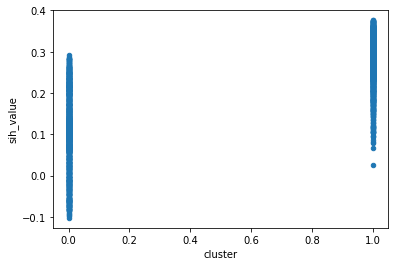

In [10]:
df_matrix.plot(x='cluster', y='sih_value', kind='scatter')

In [11]:
df_matrix.groupby('cluster').agg("mean")

sih_value
cluster           
0         0.110658
1         0.277771

### Clustering using typical energy usage with tslearn

This is to use tslearn package to do clustering based on typical energy usage, which is represented by the median values for a day in each month. 
tslearn has three metrics to choose for clustering:
- euclidean: This is the same as normal kmeans, which compares data against each timestamp and trying to put them in a cluster.
- dtw: This is dynamic time warping, which compare the shape and consider timeshifts to compare between two time series curves.
- softdtw : Main difference between dtw and softdtw is that the latter is differentiable everywhere

During the trial phase, both dtw and softdtw took too much time to finish due to the extra calculation compared to euclidean. On the other hand, for energy forecasting, using dynamic time warping does not make too much sense due to the fact that when timeshift happens, it is better to consider them different cluster since it indicates a different energy usage behavior. In the end, I decided to use euclidean metric.

In [3]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesResampler

The function below is used to find the median value of each building for each month, and compose a new vector.

In [4]:
def curve_compress(df,col,normalize=False):
    months = list(set(df['timestamp'].dt.month))
    curve =[]
    if (normalize):
        for month in months:
            temp = df[(df['timestamp'].dt.month==month) & (df['timestamp'].dt.minute==0)][['timestamp',col]].groupby(df['timestamp'].dt.time).aggregate("median")
            temp[col]=(temp[col]-min(df[col]))/(max(df[col])-min(df[col]))
            curve.extend(temp.iloc[:,0].values)
    else:
        for month in months:
            temp = df[(df['timestamp'].dt.month==month) & (df['timestamp'].dt.minute==0)][['timestamp',col]].groupby(df['timestamp'].dt.time).aggregate("median")
            curve.extend(temp.iloc[:,0].values)
    return curve.copy()

A new silhouette value calculation function is defined by using tslearn package

In [5]:
def sil_calc_tslearn(vectors, n_low=2, n_high=10,  max_iter=50, tol=1e-06, n_init=1, verbose=0):
    for n_clusters in range(n_low,n_high):
#        clusterer = KMeans(n_clusters=n_clusters)
        clusterer = TimeSeriesKMeans(n_clusters=n_clusters,metric="euclidean",metric_params={"gamma": 0.01}, verbose=verbose,  max_iter=max_iter, tol=tol, n_init=n_init)
        clusterer.fit(vectors)
        cluster_labels = clusterer.labels_
        if len(vectors) <1000:
            silhouette_avg = silhouette_score(vectors, cluster_labels)
        else:
            silhouette_avg = silhouette_score(vectors, cluster_labels, sample_size=500)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

In [ ]:
allcols=[]
com_data_zip=[]
i=0
for each in com_building:
    i=i+1
    print(i)
    cols=get_cols(each)
    allcols.extend(cols)
    for col in cols:
        temp = curve_compress(each, col,True)
        com_data_zip.append(temp)

sil_calc_tslearn(com_data_zip, n_low=2, n_high=10,  max_iter=20, tol=0.005)

The following result is printed when calculation is done
>For n_clusters = 2 The average silhouette_score is : 0.31442513713387843

>For n_clusters = 3 The average silhouette_score is : 0.23185700887003713

>For n_clusters = 4 The average silhouette_score is : 0.22320282177684694

>For n_clusters = 5 The average silhouette_score is : 0.20939944926046516

>For n_clusters = 6 The average silhouette_score is : 0.12575793313417505

>For n_clusters = 7 The average silhouette_score is : 0.12683169680099537

>For n_clusters = 8 The average silhouette_score is : 0.1477831543019828

>For n_clusters = 9 The average silhouette_score is : 0.12101891968415697

It clearly indicates that n_cluster =2 is the best one for this clustering approach. Thus a model with n_cluster=2 is built as shown below.

In [ ]:
import pickle
n_clusters=2
km = TimeSeriesKMeans(n_clusters=n_clusters,metric="euclidean",metric_params={"gamma": 0.01},max_iter=100, tol=0.005,n_init=3)
temp_cluster=[]
km.fit(com_data_zip)
with open('ts_com_model.pickle', 'wb') as f:
    pickle.dump(km, f)
cluster_list = pd.DataFrame({'blg':cols,'cluster_id':km.labels_})

with open('tscluster.pickle', 'wb') as f:
    pickle.dump(cluster_list, f)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
sih_array= silhouette_samples(com_data_zip, km.labels_)
df_matrix = pd.DataFrame({"cluster":km.labels_,"sih_value":sih_array})

In [ ]:
with open('sih_matrix_ts_c2.pickle', 'wb') as f:
    pickle.dump(df_matrix, f)

In [9]:
import pickle
with open('sih_matrix_ts_c2.pickle', 'rb') as f:
    df_matrix = pickle.load(f)

<AxesSubplot:xlabel='cluster', ylabel='sih_value'>

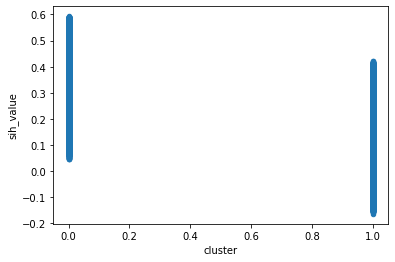

In [10]:
df_matrix.plot(x='cluster', y='sih_value', kind='scatter')

In [11]:
df_matrix.groupby('cluster').agg("mean")

sih_value
cluster           
0         0.425109
1         0.181460

### Clustering by describing the characteristic of each building with kmeans

In general, energy usage is possible to predict disregard of time, since there should be energy usage behavior when temperature and humidity changes.
From initial visualization of the data, there is some clusters for each building.

In [14]:
df = pd.read_csv(".//com//G0100790.csv",parse_dates=["timestamp"])

In [15]:
cols = [col for col in df.columns if 'tot' in col]

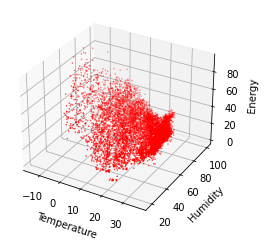

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['Temperature'],df['Humidity'], df[cols[0]],marker='.', c='r',s=1)
ax.set_xlabel('Temperature')
ax.set_ylabel('Humidity')
ax.set_zlabel('Energy')
plt.show()

<AxesSubplot:xlabel='Temperature', ylabel='150569_tot_energy'>

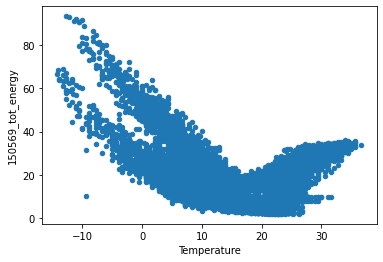

In [21]:
df.plot(kind="scatter", x='Temperature', y=cols[0])

<AxesSubplot:xlabel='Humidity', ylabel='150569_tot_energy'>

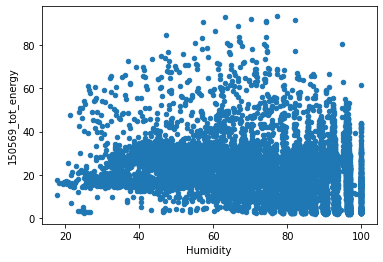

In [22]:
df.plot(kind="scatter", x='Humidity', y=cols[0])

<AxesSubplot:xlabel='Temperature', ylabel='Humidity'>

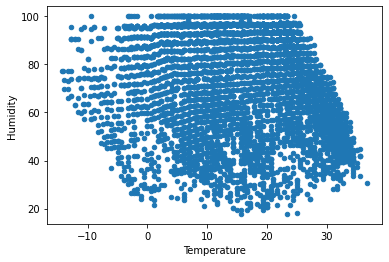

In [23]:
df.plot(kind="scatter", x='Temperature', y='Humidity')

The plot above shows the relative relationship among temperature, humidity and energy. So by doing clustering for each building based on a vector of (temperature, humidity, energy), it could capture some charactistics of the energy usage behavior. The following function will try to use the clustered information to generate a new vector per building.

In [ ]:
def vector_gen_cluster_des (dfList):
    vectors =[]
    cols =[]
    Temp_Range =[-50,50]
    cluster3=KMeans(n_clusters=3)
    for df in dfList:
        df[["Temperature","Humidity"]] = df[["Temperature","Humidity"]].interpolate(limit_direction="both")
        df['ITime'] = pd.to_datetime(df['timestamp']).astype('int64')
        df_sort = df
        col = [i for i in df_sort.columns if 'tot_energy' in i]
        temp = (df_sort['Temperature'].to_numpy()-Temp_Range[0])/100
        hum = df_sort['Humidity'].to_numpy()/100
        for each in col:
            max_c= max(df_sort[each])
            min_c= min(df_sort[each])
            eng = ((df_sort[each]-min_c)/(max_c-min_c)).to_numpy()
            vector_temp=[]
            for i in range(len(df_sort)):
                vector_temp.append([temp[i],hum[i],eng[i]])
            cluster3.fit(vector_temp)
            vector_temp2=[]
            a=sorted(cluster3.cluster_centers_.tolist())
            vector_temp2=list(np.concatenate(a, axis=None))
            vector_temp2.append(cluster3.inertia_)
            vectors.append(vector_temp2)
        cols.extend(col)
    return vectors.copy(),cols.copy()

Similar procedure is followed to find the best n_clusters for KMeans

In [ ]:
vectors, cols = vector_gen_cluster_des(com_building)
import pickle 
with open('vector_behavior.pickle', 'wb') as f:
    pickle.dump(vectors, f)

In [ ]:
def sil_calc(vectors,  n_low=2, n_high=10,n_init=10, max_iter=300, tol=0.0001, verbose=0):
    for n_clusters in range(n_low,n_high):
        clusterer = KMeans(n_clusters=n_clusters,  n_init=n_init, max_iter=max_iter, tol=tol, verbose=verbose)
        cluster_labels = clusterer.fit_predict(vectors)
        if len(vectors) <1000:
            silhouette_avg = silhouette_score(vectors, cluster_labels)
        else:
            silhouette_avg = silhouette_score(vectors, cluster_labels, sample_size=500)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

In [ ]:
sil_calc(vectors,n_low=2, n_high=10,n_init=3, max_iter=300, tol=0.0001, verbose=0)

The following is printed for each cluster:
> For n_clusters = 2 The average silhouette_score is : 0.5752013434750015

> For n_clusters = 3 The average silhouette_score is : 0.5342337272894409

> For n_clusters = 4 The average silhouette_score is : 0.5234439543194374

> For n_clusters = 5 The average silhouette_score is : 0.5261184608230619

> For n_clusters = 6 The average silhouette_score is : 0.5211828542702615

> For n_clusters = 7 The average silhouette_score is : 0.5287017761927604

> For n_clusters = 8 The average silhouette_score is : 0.5142575532968731

> For n_clusters = 9 The average silhouette_score is : 0.5157073076761006

> For n_clusters = 10 The average silhouette_score is : 0.5156716192787605

As shown above, n_clusters=2 is the best one for clustering

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
n_clusters=2
clusterer = KMeans(n_clusters=n_clusters,  n_init=10, max_iter=300, tol=0.0001)
clusterer.fit(vectors)
labels = clusterer.labels_  
sih_array= silhouette_samples(vectors, labels)
with open('sih_matrix_cluster_behavior.pickle', 'wb') as f:
    pickle.dump(df_matrix, f)
with open('kmeans_b_com_model.pickle', 'wb') as f:
    pickle.dump(clusterer, f)
with open('kmeansbcluster.pickle', 'wb') as f:
    pickle.dump(labels, f)

In [24]:
with open('sih_matrix_cluster_behavior.pickle', 'rb') as f:
    df_matrix= pickle.load(f)

<AxesSubplot:xlabel='cluster', ylabel='sih_value'>

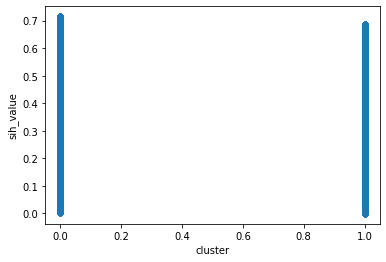

In [25]:
df_matrix.plot(x='cluster', y='sih_value', kind='scatter')

In [26]:
df_matrix.groupby('cluster').agg("mean")

sih_value
cluster           
0         0.572152
1         0.533320

## Forecasting

The forecasting below is trying to use facebook Prophet package. The main goal is to have the parameter tuned per cluster and then use the same cluster for predicting when large amount of load forecasting is required. 

### Forecast data preparation

The first step to do is to have clustering based on all clustering done above.

In [28]:
import pandas as pd
import pickle
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from tqdm import tqdm
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import itertools
import numpy as np
import warnings
init_notebook_mode(connected=False) 

In [31]:
import pickle
with open('kmeanscluster.pickle', 'rb') as f:
    kmeans_labels = pickle.load(f)
with open('tscluster.pickle', 'rb') as f:
    ts_labels = pickle.load(f)
with open('kmeansbcluster.pickle', 'rb') as f:
    kmeans_b_labels = pickle.load(f)
cols=[]
for i in range(10):
    filename= 'col_part'+str(i)+'.pickle'
    with open(filename, 'rb') as f:
        cols.extend(pickle.load(f))

In [32]:
df_labels= pd.DataFrame({"building":cols,"kmeans_label":kmeans_labels, "ts_label":ts_labels['cluster_id'].to_list(),"kmeans_b_label":kmeans_b_labels})

In [34]:
df_labels["cluster_id"]=df_labels['kmeans_label']*100+df_labels['ts_label']*10+df_labels['kmeans_b_label']

In [35]:
df_labels.head()

building  kmeans_label  ts_label  kmeans_b_label  cluster_id
0  105029_tot_energy             1         0               0         100
1  113705_tot_energy             1         0               0         100
2  117593_tot_energy             1         0               0         100
3  133033_tot_energy             1         1               0         110
4  139717_tot_energy             1         1               0         110

Once the new cluster is created, the cluster center and additional information will be required for further processing
The function vector_cluster will be used to calculate the cluster center based on new cluster label.

In [ ]:
def vector_cluster(vectors, labels,clusters, vector_per_cluster=[]):
    if len(vector_per_cluster)==0:
        vector_per_cluster= [0]*len(clusters)
    for i in range(len(vectors)):
        cluster_index=clusters.index(labels[i])
        if vector_per_cluster[cluster_index]==0:
            vector_per_cluster[cluster_index]=vectors[i]
        else:
            vector_per_cluster[cluster_index]=[i+j for (i,j) in zip(vector_per_cluster[cluster_index], vectors[i])]
    return vector_per_cluster.copy()

In [ ]:
vector_per_cluster=[]
clusters= list(set(df_labels["cluster_id"].tolist()))
min_max_array=[]
for each in com_building:
    cols = [i for i in each.columns if "tot" in i]
    labels = [df_labels["cluster_id"][df_labels['building']==col].iloc[0] for col in cols]
    temp_vectors=[]
    for col in cols:
        temp= (each[col]-min(each[col]))/(max(each[col])-min(each[col]))
        temp=temp.astype('float16')
        min_max_array.append([min(each[col]), max(each[col])])
        temp_vectors.append(temp.tolist())
    if len(vector_per_cluster)>0:
        vector_per_cluster= vector_cluster(temp_vectors, labels, clusters, vector_per_cluster)
    else:
        vector_per_cluster= vector_cluster(temp_vectors, labels, clusters)
    length =[len(i) for i in vector_per_cluster if i!=0]
    print(length)

with open('vector_per_cluster.pickle', 'wb') as f:
    pickle.dump(vector_per_cluster, f)
with open('min_max_range.pickle', 'wb') as f:
    pickle.dump(min_max_array, f)

In [36]:
with open('vector_per_cluster.pickle', 'rb') as f:
    vector_per_cluster=pickle.load(f)
with open('min_max_range.pickle', 'rb') as f:
    min_max_range=pickle.load(f)

In [37]:
clusters= list(set(df_labels["cluster_id"].tolist()))
df_centers= pd.DataFrame({"clusters":clusters, "sum":vector_per_cluster})
count_per_cluster = [len(df_labels[df_labels["cluster_id"]==i]) for i in clusters]
df_centers["number"] = count_per_cluster
df_centers["center"]= [df_centers["sum"].iloc[i]/df_centers["number"].iloc[i] for i in range(len(df_centers))]

In [38]:
df_centers

clusters                                                sum  number  \
0         0  [1801.9131889343262, 1818.5613598823547, 1832....    6201   
1         1  [3373.175832748413, 3369.872226715088, 3359.10...    7035   
2       100  [8607.155784606934, 8463.948610305786, 8324.46...   30334   
3       101  [4202.904041290283, 4182.879886627197, 4124.08...   13051   
4        10  [1308.1088438034058, 1298.4525356292725, 1275....    3646   
5        11  [3995.304620742798, 3929.038637638092, 3831.89...    9366   
6       110  [3578.0746574401855, 3332.278697371483, 3131.2...   16455   
7       111  [3518.806734085083, 3358.320059776306, 3218.03...   13521   

                                              center  
0  [0.2905842910714927, 0.29326904690894284, 0.29...  
1  [0.4794848376330367, 0.47901524189269196, 0.47...  
2  [0.2837461523243533, 0.2790251404465546, 0.274...  
3  [0.3220369351996233, 0.3205026347886903, 0.315...  
4  [0.35877916725271686, 0.35613070094055743, 0.3...  
5  [0.4265753385375612, 0.4195001748492518, 0.409...  
6  [0.21744604420785082, 0.20250858081868628, 0.1...  
7  [0.26024752119555383, 0.24837808296548378, 0.2...

In order to compensate the distance between cluster center and actual building curve, the deviation calculation for each building is required, and the following function will fullfil this requirement

In [ ]:
def vector_deviation(vectors, labels,df_centers):
    deviations =[]
    for index in range(len(vectors)):
        temp = [(i-j)**2 for (i,j) in zip(vectors[index], list(df_centers["center"][df_centers['clusters']==labels[index]].iloc[0]))]
        interval = int(len(vectors[0])/12)
        temp_vec=[]
        for month in range(12):
            temp_vec.append(sum(temp[(month*interval):(month+1)*interval])/interval)
        deviations.append(temp_vec)
    return deviations.copy()

In [ ]:
stds =[]
for each in com_building:
    cols = [i for i in each.columns if "tot" in i]
    labels = [df_labels["cluster_id"][df_labels['building']==col].iloc[0] for col in cols]
    temp_vectors=[]
    for col in cols:
        temp= (each[col]-min(each[col]))/(max(each[col])-min(each[col]))
        temp=temp.astype('float16')
        temp_vectors.append(temp.tolist())
    stds.extend(vector_deviation(temp_vectors, labels, df_centers))

In [ ]:
import math
final_stds=[]
for each in stds:
    tempstd=[math.sqrt(individual) for individual in each]
    final_stds.append(tempstd)
df_labels['std']= final_stds  

Additional building and county information is also added for futher process

In [ ]:
buildings=[each[0] for each in list(df_labels['building'].str.split(pat="_"))]
df_com_map=pd.read_csv("com_build_county.csv")
df_com_map.head()
counties = [df_com_map['in.county'][df_com_map['bldg_id']==int(blg)].iloc[0] for blg in buildings]
df_labels['county']=counties
df_labels.head()
df_labels['bldg_id']=buildings
with open('com_cluster_centers.pickle', 'wb') as f:
    pickle.dump(df_centers, f)
with open('com_cluster_stdev.pickle', 'wb') as f:
    pickle.dump(df_labels, f)

In [39]:
with open('com_cluster_centers.pickle', 'rb') as f:
    df_centers =pickle.load(f)
with open('com_cluster_stdev.pickle', 'rb') as f:
    df_labels = pickle.load(f)

In [41]:
df_labels.head()

building  kmeans_label  ts_label  kmeans_b_label  cluster_id  \
0  105029_tot_energy             1         0               0         100   
1  113705_tot_energy             1         0               0         100   
2  117593_tot_energy             1         0               0         100   
3  133033_tot_energy             1         1               0         110   
4  139717_tot_energy             1         1               0         110   

                                                 std    county bldg_id  
0  [0.17751992716523782, 0.13761466014422621, 0.1...  G0100010  105029  
1  [0.1176157676274463, 0.12308705390338681, 0.10...  G0100010  113705  
2  [0.18764893266737098, 0.13385332107999545, 0.1...  G0100010  117593  
3  [0.2997715885225028, 0.2181279739597208, 0.200...  G0100010  133033  
4  [0.18706875693385092, 0.17960437200243257, 0.1...  G0100010  139717

See above for final labels for each building and its deviation

Weather related data is extracted for Prophet model as additional regressor

In [ ]:
temp = []
humid = []
for each in com_building:
    temp.append(each['Temperature'].values)
    humid.append(each['Humidity'].values)
df_weather = pd.DataFrame({"County":counties, "Temperature": temp, "Humidity": humid})
with open('com_weather.pickle', 'wb') as f:
    pickle.dump(df_weather, f)

In [42]:
with open('com_weather.pickle', 'rb') as f:
    df_weather = pickle.load( f)

In [43]:
df_weather.head()

County                                        Temperature  \
0  G1700750  [-2.2, -2.2, -2.2, -2.2, -2.35, -2.5, -2.65, -...   
1  G1200770  [-0.5076923076923077, -0.5076923076923077, -0....   
2  G0100510  [1.1, 1.1, 1.1, 1.1, 0.9750000000000001, 0.850...   
3  G0100110  [-4.066666666666666, -4.066666666666666, -4.06...   
4  G1700510  [-7.2, -7.2, -7.2, -7.2, -7.35, -7.5, -7.65, -...   

                                            Humidity  
0  [43.98, 43.98, 43.98, 43.98, 44.955, 45.93, 46...  
1  [56.8023076923077, 56.8023076923077, 56.802307...  
2  [70.1400483337703, 70.1400483337703, 70.140048...  
3  [46.26, 46.26, 46.26, 46.26, 47.3425, 48.425, ...  
4  [47.05451747763839, 47.05451747763839, 47.0545...

### Forecast Model Tuning

There are several parameter that user can tune. According to prophet article (https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning), the following parameters are recommended to tune:
- changepoint_prior_scale
- seasonality_prior_scale
- holidays_prior_scale
- seasonality_mode: Options are ['additive', 'multiplicative']. 
For this project, changepoint_prior_scale and seasonality_prior_scale

The class suppress_stdout_stderr() and function fxn() are used to suppress loggings from prophet model so that the output is clear

In [8]:
import pandas as pd
import pickle
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from tqdm import tqdm
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import itertools
import numpy as np
import warnings
init_notebook_mode(connected=False) 

In [2]:
import os
import sys
import warnings
import pandas as pd


# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

The hypetune_prophet function is used for tuning model on n_changepoints, changepoint_prior_scale and seasonality_prior_scale for Prophet model

In [ ]:
def hypetune_prophet(df_input,n_changepoints=[4,5,6],changepoint_prior_scale=[0.15,0.2,0.5,1], seasonality_prior_scale=[0.05,0.1,0.15]):
    with warnings.catch_warnings(record=True) as w:
    # Cause all warnings to always be triggered.
        warnings.simplefilter("always")
        param_grid = {  
            'n_changepoints':n_changepoints,
            'changepoint_prior_scale': changepoint_prior_scale,
            'seasonality_prior_scale': seasonality_prior_scale
        }

        # Generate all combinations of parameters
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        mapes = []  # Store the RMSEs for each params here

        # Use cross validation to evaluate all parameters
        for params in all_params:
            with suppress_stdout_stderr():
                m = Prophet(**params).fit(df_input)  # Fit model with given params
                df_cv = cross_validation(m, initial="180 days",period='15 days', horizon ="30 days",parallel="processes")
                df_p = performance_metrics(df_cv, rolling_window=1)
            mapes.append(df_p['mape'].values[0])
    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mape'] = mapes
    return tuning_results[tuning_results['mape']==min(tuning_results['mape'])]


range_adjust function is used for adjust the input range when tuned parameter is on the edge of the original range.

In [ ]:
def range_adjust(range_org, tuned_param,interval):
    index_tuned= range_org.index(tuned_param)
    range_new=range_org.copy()
    tuned_achieved=False
    if interval!=0:
        if index_tuned >0 and index_tuned!= len(range_org)-1:
            tuned_achieved= True
            range_new =[tuned_param-interval, tuned_param, tuned_param+interval]
        else:
            tuned_achieved= False
            range_new =[tuned_param-interval, tuned_param, tuned_param+interval]
    else:
        tuned_achieved= True
    return tuned_achieved, range_new

In [ ]:
tuned_param=[]
for df_center in df_centers['center']:
    df_input= pd.DataFrame({"ds":df_sample_timestamp, 'y':df_center})
    df_input= df_input
    range1=[15,16,17,18,19,20,21,22,23,24,25]
    range2=[15]
    range3=[20]
    temp=hypetune_prophet(df_input,n_changepoints=range1,changepoint_prior_scale=range2, seasonality_prior_scale=range3)
    tuned1, new_range1 = range_adjust(range1, temp['n_changepoints'].iloc[0], 1)
    tuned2, new_range2 = range_adjust(range2, temp['changepoint_prior_scale'].iloc[0], 0)
    tuned3, new_range3 = range_adjust(range3, temp['seasonality_prior_scale'].iloc[0], 0)
    i=0
    while (~(tuned1 and tuned1 and tuned3)) and i<2:
        try:
            temp=hypetune_prophet(df_input,n_changepoints=new_range1,changepoint_prior_scale=new_range2, seasonality_prior_scale=new_range3)
        except:
            print("Exception: use ", new_range1, new_range2, new_range3, " cause issues for ", list(df_input['y'].iloc[0:5]))
            break
        tuned1, new_range1 = range_adjust(new_range1, temp['n_changepoints'].iloc[0], 1)
        tuned2, new_range2 = range_adjust(new_range2, temp['changepoint_prior_scale'].iloc[0], 0)
        tuned3, new_range3 = range_adjust(new_range3, temp['seasonality_prior_scale'].iloc[0], 0)
        i=i+1
    tuned_param.append(temp)
    print(tuned_param) 
with open('prophet_tuned_parameters.pickle', 'wb') as f:
    pickle.dump(tuned_param, f)

To forecast, when there is just several forecasting, no need to use center data to perform forecasting.
When a lot more of building curves are required to perform forecasting, the center data for each cluster will be used.

Function predict_cluster() is used when the data provided has not be analyzed beforehand. And it will be used to find out which cluster the data belongs to.
Function predict_load() is used to do the actual forecasting

In [3]:
import math
def predict_cluster (timestamp,  energy):
    if len(timestamp) < 35039:
        new_ts = [ts.replace(year=2018) for ts in timestamp]
    else:
        new_ts = [ts.replace(year=2018) for ts in timestamp[0:35039]]
    with open('timestamp.pickle', 'rb') as f:
        df_timestamp = pickle.load(f)
    energy_indices = [list(df_timestamp).index(ts) for ts in new_ts if ts in list(df_timestamp)]
    deviations =[]
    if len(energy_indices) == len (energy):
        for center in df_centers['center']:
            center_value = [center[i] for i in energy_indices]
            dev_energy = [(i-j)**2 for (i,j) in zip(energy, center_value)]
            deviations.append(sum(dev_energy)/len(center_value))
    else:
        new_energy = [energy[i] for i in range(len(timestamp)) if timestamp[i] in list(df_timestamp)]
        for center in df_centers['center']:
            center_value = [center[i] for i in energy_indices]
            dev_energy = [(i-j)**2 for (i,j) in zip(new_energy, center_value)]
            deviations.append(sum(dev_energy)/len(center_value))
    cluster_index = deviations.index(min(deviations))
    dev = [math.sqrt(min(deviations))]
    return df_centers['clusters'].iloc[cluster_index], dev

In [4]:
def predict_load (timestamp, building_ids, counties, energy, temperature, humidity, days_in_future, use_center=False, use_center_trigger_num=10 ):
    future_loading=[]
    with open('com_cluster_centers.pickle', 'rb') as f:
        df_centers=pickle.load(f)
    with open('com_cluster_stdev.pickle', 'rb') as f:
        df_std=pickle.load(f)
    with open('timestamp.pickle', 'rb') as f:
        df_timestamp = pickle.load(f)
    if use_center and len(building_ids)>use_center_trigger_num :
        labels =[]
        devs=[]
        min_maxes=[]
        for i in range(len(building_ids)):
            if building_ids[i] in list(df_std['bldg_id']):
                cluster = df_std['cluster_id'][df_std['bldg_id']==building_ids[i]].iloc[0]
                dev = df_std['std'][df_std['bldg_id']==building_ids[i]].iloc[0]
                min_max =df_std['min_max'][df_std['bldg_id']==building_ids[i]].iloc[0]
            else:
                cluster, dev = predict_cluster(timestamp, energy[i])
                min_max = [min(energy[i]), max(energy[i])]
            labels.append(cluster)
            devs.append(dev)
            min_maxes.append(min_max)
        df_cluster_items = pd.DataFrame({"cluster_id":labels, "county":counties, "std":devs,"min_max":min_maxes})
        set_cluster_county = list(set(list(zip(labels, counties))))
        unique_counties =list(set(counties))
        forecasts =[]
        ts_new = timestamp[-1].replace(year=2018)
        length = len(df_timestamp[df_timestamp<ts_new])
        for each in set_cluster_county:
            center = df_centers['center'][df_centers['clusters']==each[0]].iloc[0]
            if length >= len(timestamp):
                center_value = center[(length-len(timestamp)):length]
            else:
                diff = len(temperature) - length
                center_value_rear = center[0:length]
                center_value_front = center[-length]
                center_value = center_value_front.extend(center_value_rear)
            temp_index = unique_counties.index(each[1])
            temp_hist = temperature[temp_index][0:len(timestamp)]
            df_input = pd.DataFrame({'ds':timestamp, 'y':center_value, 'Temperature':temp_hist})
            param = df_centers['param'][df_centers['clusters']==each[0]].iloc[0]
            m = Prophet(changepoint_prior_scale=param['changepoint_prior_scale'], seasonality_prior_scale=param['seasonality_prior_scale'])
            m.add_regressor('Temperature')
            m.fit(df_input)
            future= m.make_future_dataframe(periods=days_in_future*24*4,freq="15min")
            future['Temperature']= temperature[temp_index]
            forecast = m.predict(future)
            forecasts.append(forecast)
        for i in range(len(building_ids)):
            dev_i = sum(df_cluster_items['std'].iloc[i])/ len(df_cluster_items['std'].iloc[i])
            current_cs =(df_cluster_items['cluster_id'].iloc[i], df_cluster_items['county'].iloc[i])
            set_id = set_cluster_county.index(current_cs)
            forecast_i = forecasts[set_id].copy()
            forecast_i[['yhat', 'yhat_lower', 'yhat_upper']]= forecast_i[['yhat', 'yhat_lower', 'yhat_upper']]+dev_i
            min_max_i = df_cluster_items['min_max'].iloc[i]
            forecast_i[['yhat', 'yhat_lower', 'yhat_upper']]= forecast_i[['yhat', 'yhat_lower', 'yhat_upper']]*(min_max_i[1]-min_max_i[0])+min_max_i[0]
            future_loading.append(forecast_i)
    else:
        with open('com_cluster_centers.pickle', 'rb') as f:
            df_centers=pickle.load(f)
        with open('com_cluster_stdev.pickle', 'rb') as f:
            df_std=pickle.load(f)
        for i in range(len(building_ids)):
            energy_min = min(energy[i])
            energy_max = max(energy[i])
            unique_counties =list(set(counties))
            normal_energy = [(e- energy_min)/(energy_max-energy_min) for e in energy[i]]
            temp_index = unique_counties.index(counties[i])
            temp_hist = temperature[temp_index][0:len(timestamp)]
            df_input = pd.DataFrame({'ds':timestamp, 'y':normal_energy,'Temperature':temp_hist})
            if building_ids[i] in list(df_std['bldg_id']):
                cluster = df_std['cluster_id'][df_std['bldg_id']==building_ids[i]].iloc[0]
            else:
                cluster, dev = predict_cluster(timestamp, energy[i])
            param = df_centers['param'][df_centers['clusters']==cluster].iloc[0]
#             m = Prophet(changepoint_prior_scale=param['changepoint_prior_scale'],seasonality_prior_scale=param['seasonality_prior_scale'],seasonality_mode='multiplicative')
            m = Prophet(seasonality_mode='multiplicative')
            m.add_regressor('Temperature')
            m.fit(df_input)
            future= m.make_future_dataframe(periods=days_in_future*24*4,freq="15min")
            future['Temperature'] = temperature[temp_index]
            forecast = m.predict(future)
            forecast[['yhat', 'yhat_lower', 'yhat_upper']]= forecast[['yhat', 'yhat_lower', 'yhat_upper']]*(energy_max-energy_min)+energy_min
            future_loading.append(forecast)
    return future_loading.copy()    

To test, 5 building curves for one week are prepared. The first test will do with use_center=False, and the second est will do with use_center= True.

In [6]:
with open('timestamp.pickle', 'rb') as f:
    df_timestamp = pickle.load(f)
timestamp = df_timestamp[100:(100+7*24*4)]
cols = [col for col in com_building[0].columns if "tot" in col]
building_ids = list(df_std['bldg_id'].iloc[0:5])
counties = list(df_std['county'].iloc[0:5])
energy =[com_building[0][col] for col in cols[0:5]]
part_energy=[]
for each in energy:
    part_energy.append(each[100:(100+7*24*4)])
days_in_future=3
tot_temp = len(timestamp)+3*24*4
temperature =[list(com_building[0]['Temperature'])[100:(100+tot_temp)]]
humidity =list(com_building[0]['Humidity'])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=Tru

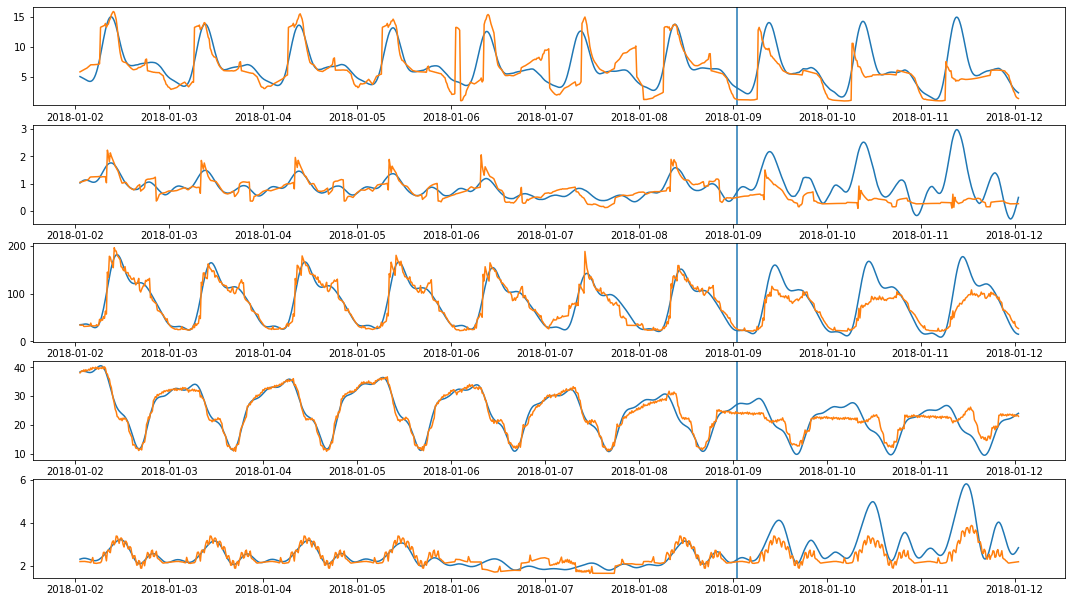

In [9]:
import matplotlib.pyplot as plt
with warnings.catch_warnings(record=True) as w:
    with suppress_stdout_stderr():
        forecasts = predict_load (list(timestamp), building_ids, counties, part_energy, temperature, humidity, days_in_future, use_center=False, use_center_trigger_num=10 )

fig, axs = plt.subplots(5, 1)
fig.set_size_inches(18.5, 10.5)
for i in range(5):
    axs[i].plot(forecasts[i]['ds'], forecasts[i]['yhat'])
    axs[i].axvline(x=list(timestamp)[-1])
    axs[i].plot(forecasts[i]['ds'],energy[i][100:(100+tot_temp)] )

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


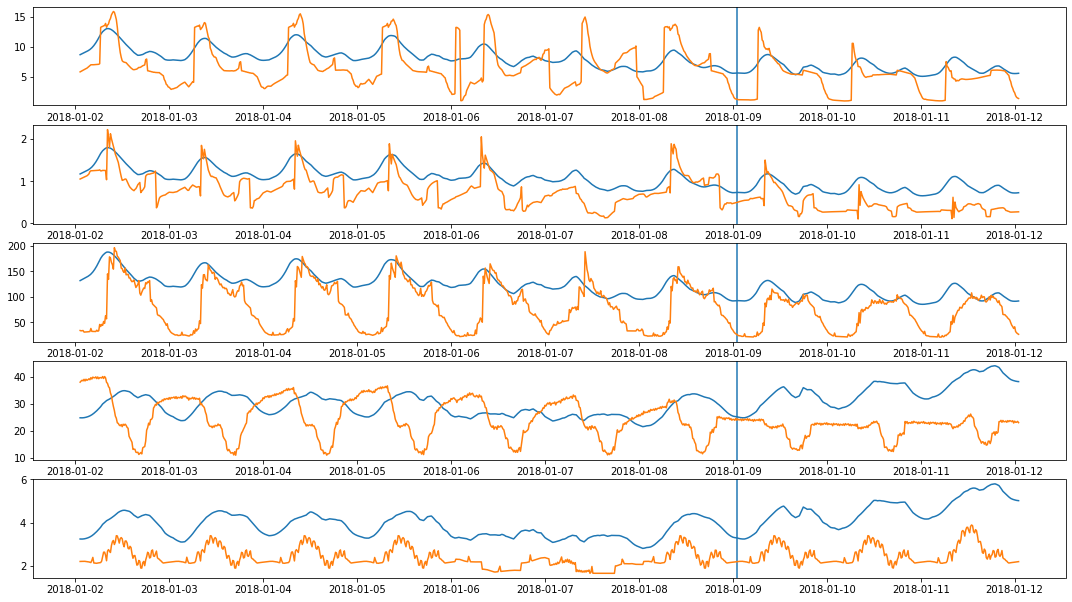

In [10]:
with warnings.catch_warnings(record=True) as w:
    with suppress_stdout_stderr():
        forecasts = predict_load (list(timestamp), building_ids, counties, part_energy, temperature, humidity, days_in_future, use_center=True, use_center_trigger_num=2 )
fig, axs = plt.subplots(5, 1)
fig.set_size_inches(18.5, 10.5)
for i in range(5):
    axs[i].plot(forecasts[i]['ds'], forecasts[i]['yhat'])
    axs[i].axvline(x=list(timestamp)[-1])
    axs[i].plot(forecasts[i]['ds'],energy[i][100:(100+tot_temp)] )